# CEE 697M - Final Project: Jerry Chen and Aniruddha Prasad


## Import Required Libraries:

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from patsy import dmatrix

# from keras.models import Sequential
# from keras.layers import Dense

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn.utils import resample

import statsmodels.api as sm
from statsmodels.gam.tests.test_penalized import df_autos
from statsmodels.gam.smooth_basis import BSplines
from statsmodels.gam.generalized_additive_model import GLMGam

import scipy as sp
from scipy.interpolate import interp1d







## Import the data:

In [24]:
# df = pd.read_spss("1ResearchProjectData.sav")
df = pd.read_csv("1ResearchProjectData.csv")

## Encode data into classes by hand to make applying models easier.
df = df.drop(columns=['wesson'])
df = df.dropna()

In [25]:
df

,Student,Teacher,Gender,Ethnic,Freeredu,Score
0,1.0,Ruger,Female,Asian,Free lunch,76.0
1,2.0,Ruger,Female,Hispanic,Paid lunch,56.0
2,3.0,Ruger,Female,African-American,Free lunch,34.0
3,4.0,Ruger,Female,Asian,Paid lunch,59.0
4,5.0,Ruger,Male,Hispanic,Free lunch,73.0
...,...,...,...,...,...,...
211,212.0,Wesson,Male,African-American,Paid lunch,56.0
212,213.0,Wesson,Male,Hispanic,Free lunch,94.0
213,214.0,Wesson,Male,Hispanic,Paid lunch,91.0
214,215.0,Wesson,Female,African-American,Paid lunch,53.0


## Pre-process the data

### Replace the name of teacher with 1, 2 or 3
 Ruger = 1
 Wesson = 2
 Smith = 3
### Replace lunch status with 0 and 1
 Free lunch = 0
 Paid lunch = 1
### Replace Gender with 1's and 0's
 Female = 0
 Male = 1
### Replace ethinicity with 1 through 4
 African American = 1
 Hispanic = 2
 Caucasian = 3
 Asian = 4

In [26]:
# Teacher
df.replace('Ruger',1,inplace=True)
df.replace('Wesson',2,inplace=True)
df.replace('Smith',3,inplace=True)

# Lunch status
df.replace('Free lunch',0,inplace=True)
df.replace('Paid lunch',1,inplace=True)

# Gender:
df.replace('Female',0,inplace=True)
df.replace('Male',1,inplace=True)

#Ethnicity
df.replace('African-American',1,inplace=True)
df.replace('Hispanic',2,inplace=True)
df.replace('Caucasian',3,inplace=True)
df.replace('Asian',4,inplace=True)

corrM = df.corr()
corrM.style.background_gradient(cmap='coolwarm').set_precision(2)

/Users/aniruddhavprasad/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`


,Student,Teacher,Gender,Ethnic,Freeredu,Score
Student,1.00,0.46,-0.03,0.03,0.00,0.37
Teacher,0.46,1.00,0.04,0.07,0.08,0.36
Gender,-0.03,0.04,1.00,-0.06,0.01,-0.13
Ethnic,0.03,0.07,-0.06,1.00,0.03,-0.01
Freeredu,0.00,0.08,0.01,0.03,1.00,-0.04
Score,0.37,0.36,-0.13,-0.01,-0.04,1.00


## Split data into Training and Validation sets:

Regression models: KNN, Multivariate Regression, OLS

Classification models: KNN, SVC, random forest classifier

### KNN Regression

In [7]:
X = pd.DataFrame(df, columns=['Teacher', 'Gender', 'Ethnic', 'Freeredu'])
y = pd.DataFrame(df, columns=['Score'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

clf = KNeighborsRegressor(n_neighbors=5, p=2)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print(f'accuracy: {clf.score(X_train, y_train)}')


accuracy: 0.27196869706231075


#### Perform gridsearch to find best hyperparameters

In [8]:
n = np.arange(1, 20, 1)
p = np.arange(1,3,1)

params = { 'n_neighbors' : n, 'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'), 'p': p  }# The param we want to figure out using the grid search
kNN = KNeighborsRegressor()
kNN_gscv = GridSearchCV(kNN, params, cv=5)# Grid search with five fold cross validation
#fit model to data
kNN_gscv.fit(X_train, y_train)
print(kNN_gscv.best_params_)

{'algorithm': 'ball_tree', 'n_neighbors': 16, 'p': 2}


#### Retrain model with the these new best hyperparams

In [9]:
knn = KNeighborsRegressor(n_neighbors=19,algorithm='brute',p=2)

knn.fit(X_train,y_train)
yPred = knn.predict(X_test)
yPred = np.around(yPred)
MSE = mean_squared_error(y_true=y_test,y_pred=yPred)
RMSE = np.sqrt(MSE)
score = knn.score(X_test,y_test)

print("The RMSE for this model is {} and the accuracy is {}".format(RMSE,score))

The RMSE for this model is 15.772419940175027 and the accuracy is 0.04190398665323691


#### Use Cross validation score to improve accuracy

C:\Users\jerry\anaconda3\envs\python37\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
C:\Users\jerry\anaconda3\envs\python37\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
C:\Users\jerry\anaconda3\envs\python37\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
C:\Users\jerry\anaconda3\envs\python37\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
C:\Users\jerry\anaconda3\envs\python37\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less th

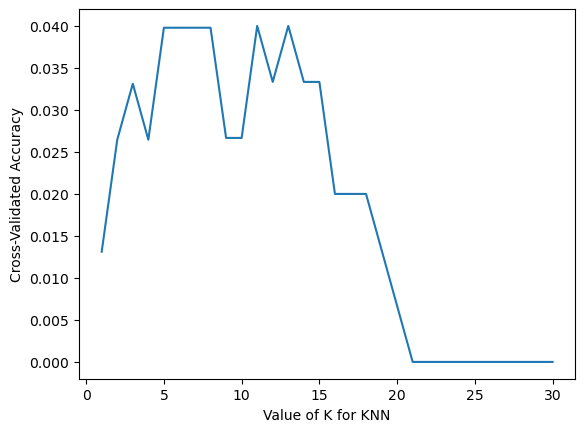

In [10]:
k_range = range(1, 31)

# list of scores from k_range
k_scores = []

# 1. we will loop through reasonable values of k
for k in k_range:
    # 2. run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute',p=2)
    # 3. obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn, X_train, y_train[:], cv=5, scoring='accuracy')
    # 4. append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())

plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()


Essentially KNN is a bad model to use here. It has given consistently low accuracy so we will instead try some other models

## Polynomial Regression with degree 1

In [42]:
X = pd.DataFrame(df, columns=['Teacher', 'Gender', 'Ethnic', 'Freeredu'])
y = pd.DataFrame(df, columns=['Score'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

poly = PolynomialFeatures(degree=1)
X_train = poly.fit_transform(X_train)
y_train = poly.fit_transform(y_train.reshape(-1,1))

X_test = poly.fit_transform(X_test)
y_test = poly.fit_transform(y_test.reshape(-1,1))

polyReg = LinearRegression()

polyReg.fit(X_train, y_train)
print(f'The training accuracy is: {polyReg.score(X_train, y_train)}')
print(f'The testing accuracy is: {polyReg.score(X_test, y_test)}')

The training accuracy is: 0.5835850088418695
The testing accuracy is: 0.5567871044864419


### Make a dummy dataset to predict the scores for a bunch of students based on the polynomial regression model

We are going to make two different X matrices. One will be a group of students taught by Ruger. The other taught by Wesson. Both groups are the same students. 
In this group of students we will have 4 of each ethnicity. Within the 4 of an ethnicity two will be female and two will be male. One male and one female will come from a good socioeconomic background and the other two will not.

In [48]:
X_ruger = pd.read_csv('rugerStud.csv')
X_wesson = pd.read_csv('wessonStud.csv')
yPred_ruger = polyReg.predict(X_ruger)
yPred_wesson = polyReg.predict(X_wesson)


/Users/aniruddhavprasad/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/aniruddhavprasad/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [59]:
print(yPred_ruger[:,1].reshape(-1,1))

[[55.72970367]
 [62.80561822]
 [59.97155973]
 [57.42350525]
 [54.58944676]
 [61.66536131]
 [58.83130282]
 [56.28324834]
 [53.44918985]
 [60.5251044 ]
 [57.69104591]
 [55.14299143]
 [52.30893294]
 [59.38484749]
 [56.550789  ]]


In [60]:
print(yPred_wesson[:,1].reshape(-1,1))

[[63.89326704]
 [70.96918159]
 [68.1351231 ]
 [65.58706862]
 [62.75301013]
 [69.82892468]
 [66.99486619]
 [64.44681171]
 [61.61275322]
 [68.68866777]
 [65.85460928]
 [63.3065548 ]
 [60.47249631]
 [67.54841086]
 [64.71435237]]


## ANN

In [25]:
X = pd.DataFrame(df, columns=['Teacher', 'Gender', 'Ethnic', 'Freeredu'])
y = pd.DataFrame(df, columns=['Score'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# First we create the model for the ANN
model = Sequential()

# Now define the input layer and the hidden layer
model.add(Dense(units=2, input_dim=4, kernel_initializer='normal', activation='relu'))

# Now define the second layer also with a relu activation
model.add(Dense(units=5, kernel_initializer='normal',activation='tanh'))

# Finally connect the output layer 
model.add(Dense(1,kernel_initializer='normal'))

# Compile the model with MSE as loss
model.compile(loss='mean_squared_error',optimizer='adam')

# Fit to training set use a large number of epochs for example 40

model.fit(X_train,y_train,batch_size=20,epochs=50,verbose=0)


# Manual grid search
# Defining a function to find the best parameters for ANN
def FunctionFindBestParams(X_train, y_train, X_test, y_test):
    
    # Defining the list of hyper parameters to try
    batch_size_list=[5, 10, 15, 20]
    epoch_list  =   [5, 10, 50, 100]
    
    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'Accuracy'])
    
    # initializing the trials
    TrialNumber=0
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber+=1
            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units=5, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
 
            # Defining the Second layer of the model
            model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))
 
            # The output neuron is a single fully connected node 
            # Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal'))
 
            # Compiling the model
            model.compile(loss='mean_squared_error', optimizer='adam')
 
            # Fitting the ANN to the Training set
            model.fit(X_train, y_train ,batch_size = batch_size_trial, epochs = epochs_trial, verbose=0)
 
            MAPE = np.mean(100 * (np.abs(y_test-model.predict(X_test))/y_test))
            
            # printing the results of the current iteration
            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100-MAPE)
            
            SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE]],
                                                                    columns=['TrialNumber', 'Parameters', 'Accuracy'] ))
    return(SearchResultsData)
 
 
# Calling the function
ResultsData=FunctionFindBestParams(X_train, y_train, X_test, y_test)
ResultsData


1 Parameters: batch_size: 5 - epochs: 5 Accuracy: Score    1.670974
dtype: float64
2 Parameters: batch_size: 5 - epochs: 10 Accuracy: Score    9.471028
dtype: float64
3 Parameters: batch_size: 5 - epochs: 50 Accuracy: Score    74.194569
dtype: float64
4 Parameters: batch_size: 5 - epochs: 100 Accuracy: Score    75.719829
dtype: float64
5 Parameters: batch_size: 10 - epochs: 5 Accuracy: Score    0.410896
dtype: float64
6 Parameters: batch_size: 10 - epochs: 10 Accuracy: Score    0.260695
dtype: float64
7 Parameters: batch_size: 10 - epochs: 50 Accuracy: Score    74.417301
dtype: float64
8 Parameters: batch_size: 10 - epochs: 100 Accuracy: Score    74.421509
dtype: float64
9 Parameters: batch_size: 15 - epochs: 5 Accuracy: Score    0.139605
dtype: float64
10 Parameters: batch_size: 15 - epochs: 10 Accuracy: Score    0.178804
dtype: float64
11 Parameters: batch_size: 15 - epochs: 50 Accuracy: Score    63.341574
dtype: float64
12 Parameters: batch_size: 15 - epochs: 100 Accuracy: Score    

,TrialNumber,Parameters,Accuracy
0,1,5-5,Score 1.670974 dtype: float64
0,2,5-10,Score 9.471028 dtype: float64
0,3,5-50,Score 74.194569 dtype: float64
0,4,5-100,Score 75.719829 dtype: float64
0,5,10-5,Score 0.410896 dtype: float64
0,6,10-10,Score 0.260695 dtype: float64
0,7,10-50,Score 74.417301 dtype: float64
0,8,10-100,Score 74.421509 dtype: float64
0,9,15-5,Score 0.139605 dtype: float64
0,10,15-10,Score 0.178804 dtype: float64


In [35]:
X = pd.DataFrame(df, columns=['Teacher', 'Gender', 'Ethnic', 'Freeredu'])
y = pd.DataFrame(df, columns=['Score'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# First we create the model for the ANN
model = Sequential()

# Now define the input layer and the hidden layer
model.add(Dense(units=2, input_dim=4, kernel_initializer='normal', activation='relu'))

# Now define the second layer also with a relu activation
model.add(Dense(units=5, kernel_initializer='normal',activation='tanh'))

# Finally connect the output layer 
model.add(Dense(1,kernel_initializer='normal'))

# Compile the model with MSE as loss
model.compile(loss='mean_squared_error',optimizer='adam')

# Fit to training set use a large number of epochs for example 40

model.fit(X_train,y_train,batch_size=5,epochs=100,verbose=0)
model.score(X_test,y_test)

AttributeError: 'Sequential' object has no attribute 'score'

In [32]:
# Separate Target Variable and Predictor Variables
TargetVariable=['Score']
Predictors=['Teacher', 'Gender', 'Ethnic', 'Freeredu']

### Sandardization of data ###
PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()
 
# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
TargetVarScalerFit=TargetVarScaler.fit(y)

# Generating Predictions on testing data
Predictions=model.predict(X_test)

# Scaling the predicted score data back to original score scale
Predictions=TargetVarScalerFit.inverse_transform(Predictions)

# Scaling the y_test score data back to original score scale
y_test_orig=TargetVarScalerFit.inverse_transform(y_test)

# Scaling the test data back to original scale
Test_Data=PredictorScalerFit.inverse_transform(X_test)

TestingData=pd.DataFrame(data=Test_Data, columns=Predictors)
TestingData['Score']=y_test_orig
TestingData['PredictedScore']=Predictions
TestingData.head()

,Teacher,Gender,Ethnic,Freeredu,Score,PredictedScore
0,3.600787,1.052460,5.772602,1.018175,1354.832419,385.158447
1,3.600787,1.052460,4.667846,1.018175,1550.714840,385.157074
2,4.405810,0.555556,6.877358,1.018175,1224.244139,385.158752
3,3.600787,0.555556,6.877358,0.518519,1403.803025,385.157898
4,2.795764,1.052460,6.877358,0.518519,1175.273534,385.157562
